# Multiple Obstacle Avoidance

This is a notebook designed to kickstart the project. Before we introduce dynamic obstacles, let's start by finding the optimal trajectory through a collection of multiple static obstacles.

In [410]:
import numpy as np
from scipy.integrate import solve_bvp
from matplotlib import pyplot as plt
from functools import partial
from scipy.integrate import trapz

## Obstacle Setup

In [411]:
def obstacle(x, y, W1=1, r=(1, 1), c=(0, 0)):
    '''
    Define an area that will represent an obstacle
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**20 + 1

    return W1 / ellipse

def obstacle_dx(x, y, W1=1, r=(1, 1,), c=(0, 0)):
    '''
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x, y, W1=1, r=(1, 1,), c=(0, 0)):
    '''
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

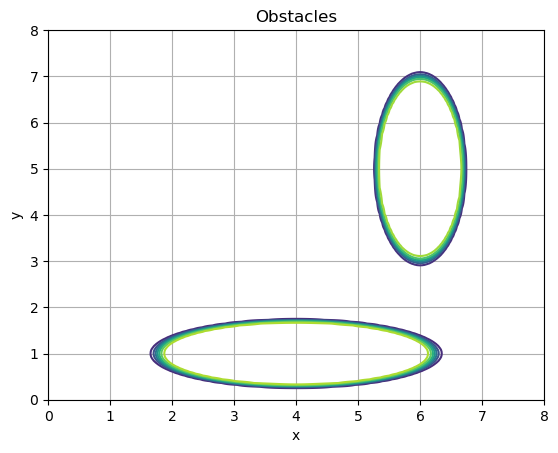

In [412]:
c1 = (4, 1)
r1 = (5, 0.5)
c2 = (6, 5)
r2 = (0.5, 4)
W1_1 = 4
W1_2 = 1

x_linspace = np.linspace(0, 8, 200)
y_linspace = np.linspace(0, 8, 200)

plt.figure()
plt.title("Obstacles")

X, Y = np.meshgrid(x_linspace, y_linspace)
Z1 = obstacle(X, Y, W1_1, r1, c1)
Z2 = obstacle(X, Y, W1_2, r2, c2)

plt.contour(X, Y, Z1)
plt.contour(X, Y, Z2)

plt.xlabel('x')
plt.ylabel('y')
plt.grid()

plt.show()

## Target Locations

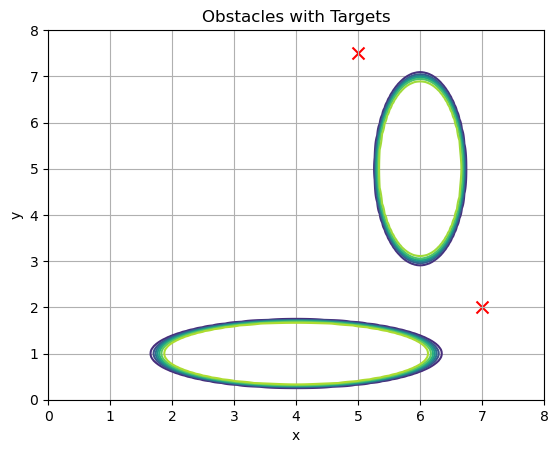

In [413]:
target1 = (7, 2)
target2 = (5, 7.5)

plt.figure()
plt.title("Obstacles with Targets")

plt.contour(X, Y, Z1)
plt.contour(X, Y, Z2)

plt.scatter(*target1, c='r', marker='x', s=75, label='target')
plt.scatter(*target2, c='r', marker='x', s=75)

plt.xlabel('x')
plt.ylabel('y')
plt.grid()

plt.show()

## Optimal Control: target 1 --> target 2

Suppose that the agent begins at the origin.

In [445]:
t0 = 0
# tf unknown

beta = 5
W2 = 1

s0 = [0, 0, 0, 0]

def make_ode(r, c, target, s0, W1):
    def ode(t, y, p):
        s1, s2, s3, s4, p1, p2, p3, p4 = y
        return p[0] * np.array([
            s3,
            s4,
            p3 / (2 * W2),
            p4 / (2 * W2),
            obstacle_dx(s1, s2, W1, r, c),
            obstacle_dy(s1, s2, W1, r, c),
            -p1,
            -p2
        ])
    return ode

def make_bc(r, c, target, s0, W1):
    def bc(ya, yb, p):
        s1, s2, s3, s4, p1, p2, p3, p4 = yb
        u1, u2 = 0.5 * p3 / W2, 0.5 * p4 / W2
        H = p1*s3 + p2*s4 + p3*u1 + p4*u2 - (1 + beta * obstacle(s1, s2, W1, r, c) + W2 * (u1**2 + u2**2))
        return [
            ya[0] - s0[0],
            ya[1] - s0[1],
            ya[2] - s0[2],
            ya[3] - s0[3],
            yb[0] - target[0],
            yb[1] - target[1],
            yb[2],
            yb[3],
            H
        ]
    return bc

t_steps = 100
t = np.linspace(0, 1, t_steps)
y0_1 = np.ones((8, t_steps))
x = np.linspace(0, 7, t_steps)
y1 = (1.75 / 3) * x[x <= 3]
y2 = ((2 - 1.75) / (7 - 3)) * (x[x > 3] - 3) + 1.75
y_init = np.concatenate((y1, y2))
y0_1[0, :] = x
y0_1[1, :] = y_init
p0 = np.array([3])

ode = make_ode(r1, c1, target1, s0, W1_1)
bc = make_bc(r1, c1, target1, s0, W1_1)

sol1 = solve_bvp(ode, bc, t, y0_1, p0, max_nodes=60_000)

# Now run similarly to get to target 2
y0_2 = np.ones((8, t_steps))
x = np.linspace(target1[0], target2[0], t_steps)
# (7, 2) -> (6.5, 7)
x1 = x[x >= 6.5]
y1 = ((7 - 2) / (6.5 - 7)) * (x1 - 7) + 2
# (6.5, 7) -> (5, 7.5)
x2 = x[x < 6.5]
y2 = ((7.5 - 7) / (5 - 6.5)) * (x2 - 6.5) + 7
y_init = np.concatenate((y1, y2))

y0_2[0, :] = x[::-1]  
y0_2[1, :] = y_init[::-1]  

s0 = [sol1.y[0, -1], sol1.y[1, -1], 0, 0]

# Try p0 closer to sol1's solution or previous successful values
p0 = np.array([sol1.p[0]]) 

# Ensure obstacle parameters (r2, c2) are correct
ode = make_ode(r2, c2, target2, s0, W1_2)  # Check r2 and c2
bc = make_bc(r2, c2, target2, s0, W1_2)

sol2 = solve_bvp(ode, bc, t, y0_2, p0, max_nodes=60_000)


Total Cost: 3038.876
final time to target 1: 7.000
final time to target 2: 6.896


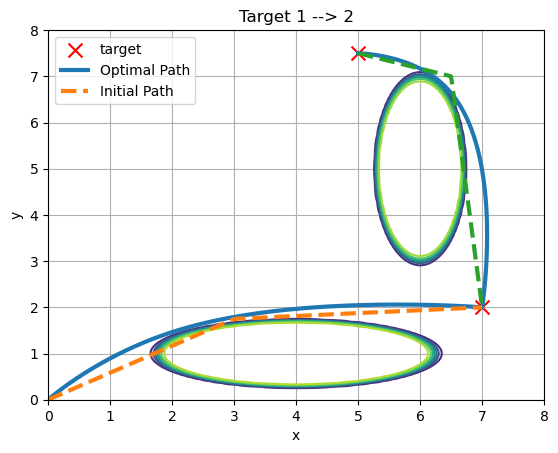

In [446]:
x1, y1 = sol1.y[0], sol1.y[1]
ux1, uy1 = sol1.y[6] / (2 * W2), sol1.y[7] / (2 * W2)

x2, y2 = sol2.y[0], sol2.y[1]
ux2, uy2 = sol2.y[6] / (2 * W2), sol2.y[7] / (2 * W2)

x = np.concatenate((x1, x2))
y = np.concatenate((y1, y2))
ux = np.concatenate((ux1, ux2))
uy = np.concatenate((uy1, uy2))
u = np.vstack((ux, uy))

tf = np.abs(sol1.p[0]) + np.abs(sol2.p[0])

params = {
    1: [x1, y1, W1_1, r1, c1],
    2: [x2, y2, W1_2, r2, c2]
}

def total_cost(u, params, tf):

    obstacle_cost = sum([trapz(obstacle(*vals)) for vals in params.values()])
    input_cost = trapz(np.linalg.norm(u, axis=0)**2)
    return tf + obstacle_cost + input_cost

tc = total_cost(u, params, tf)
print(f"Total Cost: {tc:.3f}")


print(f"final time to target 1: {sol1.p[0]:.3f}")
print(f"final time to target 2: {sol2.p[0]:.3f}")

plt.figure()
plt.title("Target 1 --> 2")

plt.contour(X, Y, Z1)
plt.contour(X, Y, Z2)

plt.scatter(*target1, c='r', marker='x', s=100, label='target')
plt.scatter(*target2, c='r', marker='x', s=100)

plt.plot(x, y, label='Optimal Path', lw=3)
plt.plot(y0_1[0], y0_1[1], label='Initial Path', lw=3, linestyle='--')

# plt.plot(x2, y2, lw=3)
plt.plot(y0_2[0], y0_2[1], lw=3, linestyle='--')

plt.xlabel('x')
plt.ylabel('y')
plt.grid()

plt.legend()
plt.show()

## Optimal Control: Target 2 --> 1

In [389]:
c1 = (4, 1)
r1 = (5, 0.5)
c2 = (6, 5)
r2 = (0.5, 4)
W1_1 = 4
W1_2 = 1
beta = 1

In [434]:
s0 = [0, 0, 0, 0]
t_steps = 100
t = np.linspace(0, 1, 100)

y0_1 = np.ones((8, t_steps))
x = np.linspace(0, 5, t_steps)
y0_1[0, :] = x
y0_1[1, :] = 7.5 / 5 * x
p0 = np.array([3])

ode = make_ode(r1, c1, target2, s0, W1_1)
bc = make_bc(r1, c1, target2, s0, W1_1)

sol1 = solve_bvp(ode, bc, t, y0_1, p0, max_nodes=60_000)

s0 = [sol1.y[0, -1], sol1.y[1, -1], 0, 0]
p0 = np.array([sol1.p[0]])

waypoint = (7.0, 7.5)

# Create piecewise x-linspace from (5, 7.5) -> (6, 8) -> (7, 2)
t_steps = 100
x_segment1 = np.linspace(5, waypoint[0], t_steps//2)
x_segment2 = np.linspace(waypoint[0], 7, t_steps//2)

# Use linear or custom interpolation for y
y_segment1 = np.linspace(7.5, waypoint[1], t_steps//2)
y_segment2 = np.linspace(waypoint[1], 2.0, t_steps//2)

x = np.concatenate([x_segment1, x_segment2])
y_init = np.concatenate([y_segment1, y_segment2])

# Fill in y0_2
y0_2 = np.ones((8, t_steps))
y0_2[0, :] = x
y0_2[1, :] = y_init
y0_2[2, :] *= 2
y0_2[3, :] *= -1


ode = make_ode(r2, c2, target1, s0, W1_2)
bc = make_bc(r2, c2, target1, s0, W1_2)

sol2 = solve_bvp(ode, bc, t, y0_2, p0, max_nodes=60_000)


Total Cost: 152.269
final time to target 2: 7.350380088738928
final time to target 1: 6.896254056914962


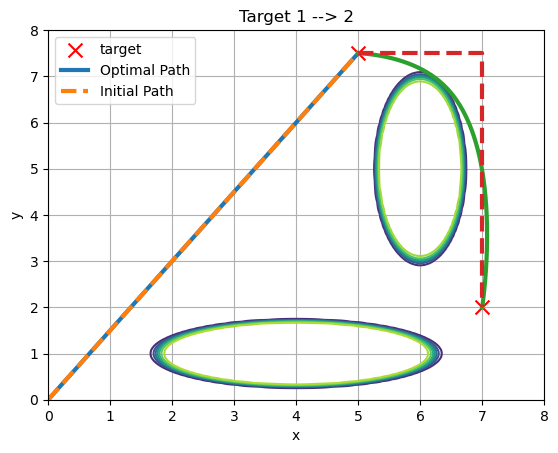

In [435]:
x1, y1 = sol1.y[0], sol1.y[1]
ux1, uy1 = sol1.y[6] / (2 * W2), sol1.y[7] / (2 * W2)
x2, y2 = sol2.y[0], sol2.y[1]
ux2, uy2 = sol2.y[6] / (2 * W2), sol2.y[7] / (2 * W2)
u = np.vstack((np.concatenate((ux1, ux2)), np.concatenate((uy1, uy2))))

params = {
    1: [x1, y1, W1_1, r1, c1],
    2: [x2, y2, W1_2, r2, c2]
}

tf = sol1.p[0] + sol2.p[0]

tc = total_cost(u, params, tf)

print(f"Total Cost: {tc:.3f}")


print(f"final time to target 2: {sol1.p[0]}")
print(f"final time to target 1: {sol2.p[0]}")

plt.figure()
plt.title("Target 1 --> 2")

plt.contour(X, Y, Z1)
plt.contour(X, Y, Z2)

plt.scatter(*target1, c='r', marker='x', s=100, label='target')
plt.scatter(*target2, c='r', marker='x', s=100)

plt.plot(x1, y1, label='Optimal Path', lw=3)
plt.plot(y0_1[0], y0_1[1], label='Initial Path', lw=3, linestyle='--')

plt.plot(x2, y2, lw=3)
plt.plot(y0_2[0], y0_2[1], lw=3, linestyle='--')

plt.xlabel('x')
plt.ylabel('y')
plt.grid()

plt.legend()
plt.show()